In [1]:
import pandas as pd
import matplotlib.pyplot as plt

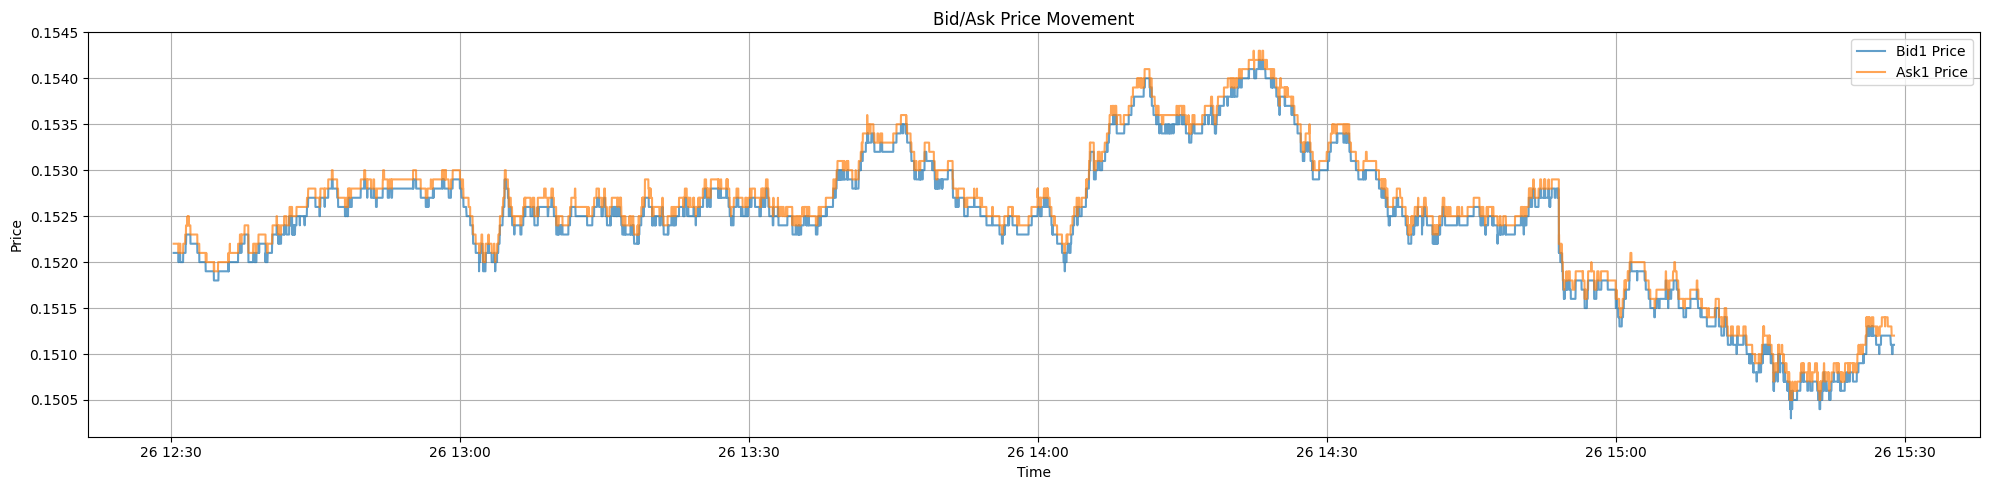

In [27]:


df = pd.read_csv('../csv_orderbook_one/./././././orderbook_gateio_AI16Z_USDT_USDT.csv')

# ⏱ Convert timestamp to datetime for clarity
df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')

# 🎨 Start plotting
plt.figure(figsize=(20, 5))

# Dashed bid lines
plt.plot(df['datetime'], df['bid1_price'], '-', alpha=0.7, label='Bid1 Price')
# plt.plot(df['datetime'], df['bid2_price'], 'c--', alpha=0.7, label='Bid2 Price')

# Solid ask lines
plt.plot(df['datetime'], df['ask1_price'], '-', alpha=0.7, label='Ask1 Price')
# plt.plot(df['datetime'], df['ask2_price'], 'm-', alpha=0.7, label='Ask2 Price')

# 🧭 Layout
plt.title('Bid/Ask Price Movement')
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

/tmp/ipykernel_105745/2396193372.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10")  # 兼容性更强


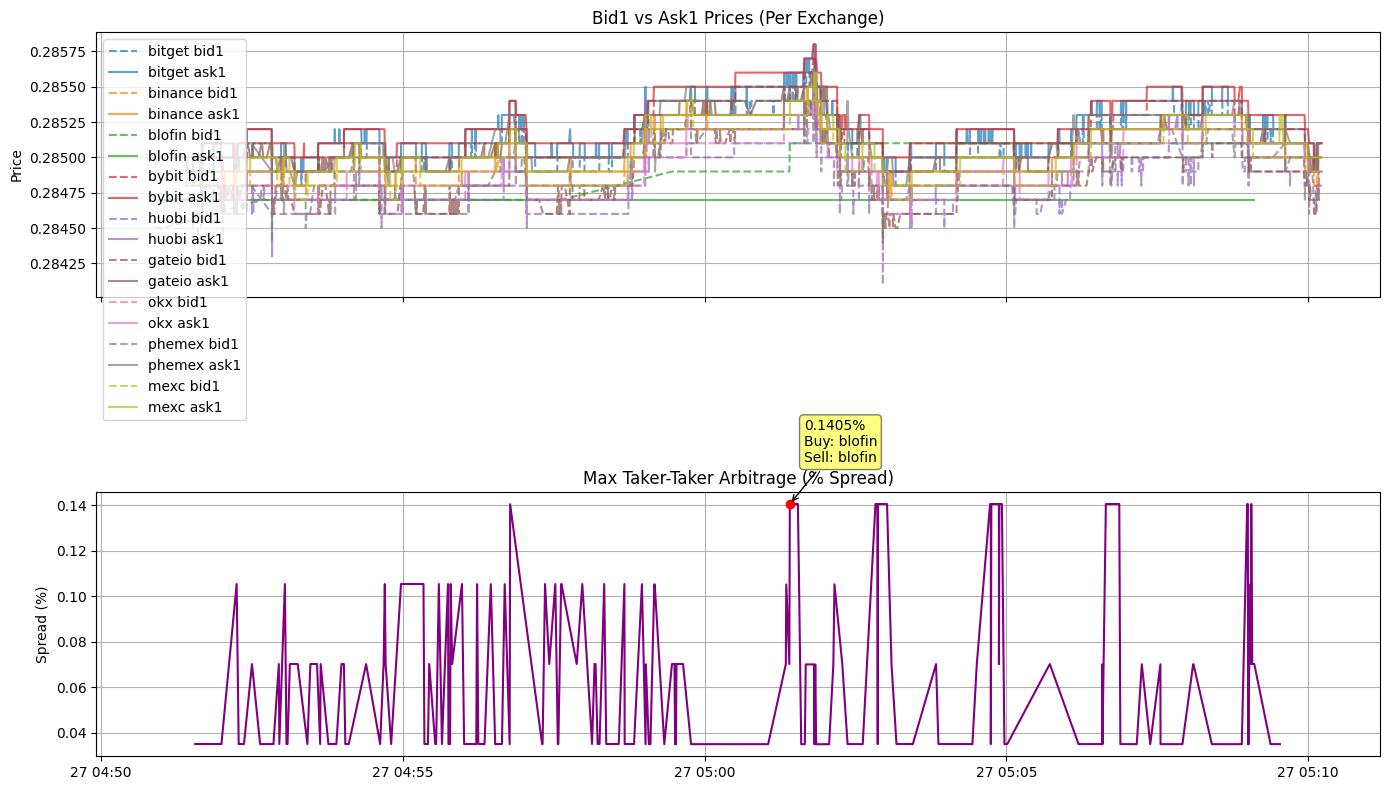

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# 加载数据
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

df = pd.read_csv("../csv_orderbooks_symbol/ob_1INCH_USDT_USDT.csv")

df["datetime"] = pd.to_datetime(df["timestamp"], unit="ms")

# ✅ 动态分配颜色给交易所
exchanges = df["exchange"].unique()
cmap = cm.get_cmap("tab10")  # 兼容性更强
exchange_colors = {ex: cmap(i / len(exchanges)) for i, ex in enumerate(exchanges)}

# ✅ 设置画布和子图
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# 📈 子图1：绘制每个交易所的 bid1 和 ask1
for ex in exchanges:
    sub = df[df["exchange"] == ex]
    ax1.plot(sub["datetime"], sub["bid1_price"], linestyle="--", alpha=0.7,
             label=f"{ex} bid1", color=exchange_colors[ex])
    ax1.plot(sub["datetime"], sub["ask1_price"], linestyle="-", alpha=0.7,
             label=f"{ex} ask1", color=exchange_colors[ex])

ax1.set_title("Bid1 vs Ask1 Prices (Per Exchange)")
ax1.set_ylabel("Price")
ax1.legend()
ax1.grid(True)

# 📉 子图2：套利分析（按买入价显示百分比）
arbs = []
for time, group in df.groupby("datetime"):
    bid_row = group.loc[group["bid1_price"].idxmax()]
    ask_row = group.loc[group["ask1_price"].idxmin()]
    spread = bid_row["bid1_price"] - ask_row["ask1_price"]
    if spread > 0:
        pct = (spread / ask_row["ask1_price"]) * 100  # 按买入价计算百分比
        arbs.append({
            "time": time,
            "spread_pct": pct,
            "buy_ex": ask_row["exchange"],
            "sell_ex": bid_row["exchange"]
        })

# ✅ 绘制套利图
arbs_df = pd.DataFrame(arbs)
ax2.plot(arbs_df["time"], arbs_df["spread_pct"], label="Arbitrage %", color="purple")
ax2.set_title("Max Taker-Taker Arbitrage (% Spread)")
ax2.set_ylabel("Spread (%)")
ax2.grid(True)

# 🔴 标记最大套利点
if not arbs_df.empty:
    max_row = arbs_df.loc[arbs_df["spread_pct"].idxmax()]
    ax2.plot(max_row["time"], max_row["spread_pct"], "ro")
    ax2.annotate(
        f"{max_row['spread_pct']:.4f}%\nBuy: {max_row['buy_ex']}\nSell: {max_row['sell_ex']}",
        xy=(max_row["time"], max_row["spread_pct"]),
        xytext=(10, 30),
        textcoords="offset points",
        arrowprops=dict(arrowstyle="->"),
        bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.5)
    )

# ✅ 保存为图像
plt.tight_layout()


plt.show()
plt.savefig("orderbook_spread.png")
plt.close()
# plt.savefig("orderbook_spread.png")
# plt.close()



In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def plot_orderbook_arbitrage(df, symbol_name, save_path):
    df["datetime"] = pd.to_datetime(df["timestamp"], unit="ms")
    exchanges = df["exchange"].unique()
    cmap = cm.get_cmap("tab10")
    exchange_colors = {ex: cmap(i / len(exchanges)) for i, ex in enumerate(exchanges)}

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

    # 📈 Bid1 / Ask1 图像
    for ex in exchanges:
        sub = df[df["exchange"] == ex]
        ax1.plot(sub["datetime"], sub["bid1_price"], linestyle="--", alpha=0.7,
                 label=f"{ex} bid1", color=exchange_colors[ex])
        ax1.plot(sub["datetime"], sub["ask1_price"], linestyle="-", alpha=1,
                 label=f"{ex} ask1", color=exchange_colors[ex])

    ax1.set_title(f"{symbol_name} Bid1 vs Ask1")
    ax1.set_ylabel("Price")
    ax1.legend()
    ax1.grid(True)

    # 📉 套利百分比图
    arbs = []
    for time, group in df.groupby("datetime"):
        bid_row = group.loc[group["bid1_price"].idxmax()]
        ask_row = group.loc[group["ask1_price"].idxmin()]
        spread = bid_row["bid1_price"] - ask_row["ask1_price"]
        if spread > 0:
            pct = (spread / ask_row["ask1_price"]) * 100
            arbs.append({
                "time": time,
                "spread_pct": pct,
                "buy_ex": ask_row["exchange"],
                "sell_ex": bid_row["exchange"]
            })

    arbs_df = pd.DataFrame(arbs)
    ax2.plot(arbs_df["time"], arbs_df["spread_pct"], label="Arbitrage %", color="purple")
    ax2.set_title(f"{symbol_name} Taker-Taker Arbitrage (% Spread)")
    ax2.set_ylabel("Spread (%)")
    ax2.grid(True)

    # 🔴 标记最大套利点
    if not arbs_df.empty:
        max_row = arbs_df.loc[arbs_df["spread_pct"].idxmax()]
        ax2.plot(max_row["time"], max_row["spread_pct"], "ro")
        ax2.annotate(
            f"{max_row['spread_pct']:.4f}%\nBuy: {max_row['buy_ex']}\nSell: {max_row['sell_ex']}",
            xy=(max_row["time"], max_row["spread_pct"]),
            xytext=(10, 30),
            textcoords="offset points",
            arrowprops=dict(arrowstyle="->"),
            bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.5)
        )

    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

# 🚀 批量遍历并绘图
csv_dir = "../csv_orderbooks_symbol"
output_dir = "arb_charts"
os.makedirs(output_dir, exist_ok=True)

for fname in os.listdir(csv_dir):
    if fname.endswith(".csv"):
        fpath = os.path.join(csv_dir, fname)
        symbol = os.path.splitext(fname)[0]
        try:
            df = pd.read_csv(fpath)
            save_path = os.path.join(output_dir, f"{symbol}.png")
            plot_orderbook_arbitrage(df, symbol, save_path)
            print(f"✅ 图像已保存: {save_path}")
        except Exception as e:
            print(f"⚠️ 处理 {fname} 时出错: {e}")


/tmp/ipykernel_105745/2352811760.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10")


✅ 图像已保存: arb_charts/ob_AERGO_USDT_USDT.png


/tmp/ipykernel_105745/2352811760.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10")


✅ 图像已保存: arb_charts/ob_1INCH_USDT_USDT.png


/tmp/ipykernel_105745/2352811760.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10")


✅ 图像已保存: arb_charts/ob_ACH_USDT_USDT.png


/tmp/ipykernel_105745/2352811760.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10")


✅ 图像已保存: arb_charts/ob_AEVO_USDT_USDT.png


/tmp/ipykernel_105745/2352811760.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10")


✅ 图像已保存: arb_charts/ob_ADA_USDT_USDT.png


/tmp/ipykernel_105745/2352811760.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10")


✅ 图像已保存: arb_charts/ob_ACT_USDT_USDT.png


/tmp/ipykernel_105745/2352811760.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10")


✅ 图像已保存: arb_charts/ob_ACE_USDT_USDT.png


/tmp/ipykernel_105745/2352811760.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10")


✅ 图像已保存: arb_charts/ob_A_USDT_USDT.png


/tmp/ipykernel_105745/2352811760.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10")


✅ 图像已保存: arb_charts/ob_AAVE_USDT_USDT.png


/tmp/ipykernel_105745/2352811760.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10")


✅ 图像已保存: arb_charts/ob_AERO_USDT_USDT.png
